In [1]:
from sklearn import linear_model
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from group_lasso import GroupLasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

%matplotlib inline
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train_dataset.csv')
train_top = pd.read_csv('train_dataset_top.csv')
train_bottom = pd.read_csv('train_dataset_bot.csv')

test = pd.read_csv('test_dataset.csv')
test_top = pd.read_csv('test_dataset_top.csv')
test_bottom = pd.read_csv('test_dataset_bot.csv')

val= pd.read_csv('val_dataset.csv')
val_top = pd.read_csv('val_dataset_top.csv')
val_bottom = pd.read_csv('val_dataset_bot.csv')

In [3]:
print(train.shape)
print(test.shape)
print(val.shape)

test_top.head()

(405107, 919)
(285562, 919)
(136600, 919)


,Unnamed: 0,permno,DATE,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,...,invest*dfy,invest*svar,absacc*dp_sp,absacc*ep_sp,absacc*bm_sp,absacc*ntis,absacc*tbl,absacc*tms,absacc*dfy,absacc*svar
0,0,14593,202112,1.000000,-0.517544,-0.917058,0.083234,0.935369,-0.766950,-0.369577,...,-0.337816,-0.407181,-0.870484,-0.809642,-0.864945,0.345191,-0.994172,-0.563798,-0.920009,-0.988168
1,1,14593,202109,0.850689,-0.513482,-0.915312,0.090737,0.932078,-0.755616,-0.124235,...,-0.335102,-0.408639,-0.859405,-0.813324,-0.854991,0.361192,-0.996115,-0.574823,-0.913856,-0.993453
2,2,10107,202111,0.835936,-0.613520,-0.953011,0.035643,0.942327,-0.801956,-0.176537,...,-0.329061,-0.408331,-0.893346,-0.848228,-0.886988,0.341805,-0.996143,-0.592870,-0.935504,-0.995051
3,3,10107,202112,0.830225,-0.612965,-0.952832,0.055599,0.935369,-0.804418,-0.335381,...,-0.329728,-0.406433,-0.897154,-0.848841,-0.892756,0.328896,-0.995372,-0.603814,-0.936481,-0.990605
4,4,14593,202111,0.812219,-0.513624,-0.915374,0.004744,0.942327,-0.764305,-0.243932,...,-0.337273,-0.408725,-0.865688,-0.808870,-0.857681,0.361447,-0.995143,-0.550015,-0.918778,-0.993767


In [4]:
test.drop(test.columns[0], axis=1, inplace=True)
test.dropna(inplace=True)

train.drop(train.columns[0], axis=1, inplace=True)
train.dropna(inplace=True)

val.drop(val.columns[0], axis=1, inplace=True)
val.dropna(inplace=True)

test_top.drop(test_top.columns[0], axis=1, inplace=True)
test_top.dropna(inplace=True)

train_top.drop(train_top.columns[0], axis=1, inplace=True)
train_top.dropna(inplace=True)

val_top.drop(val_top.columns[0], axis=1, inplace=True)
val_top.dropna(inplace=True)

test_bottom.drop(test_bottom.columns[0], axis=1, inplace=True)
test_bottom.dropna(inplace=True)

train_bottom.drop(train_bottom.columns[0], axis=1, inplace=True)
train_bottom.dropna(inplace=True)

val_bottom.drop(val_bottom.columns[0], axis=1, inplace=True)
val_bottom.dropna(inplace=True)

Out of Sample R-Squared

In [5]:
def R_oss(true,pred):
    true = np.array(true)
    pred = np.array(pred).flatten()
    numer = np.dot((true-pred),(true-pred))
    denom = np.dot(true,true)
    frac = numer/denom
    return 1-frac

Huber loss function calculation

In [6]:
def HuberLoss(true,pred,epsilon):
    true=true.reshape((true.shape[0],1))
    residual = true-pred
    huber_loss = np.where((np.abs(residual)<1),residual**2,2*epsilon*(np.abs(residual)-0.5*epsilon))
    return np.mean(huber_loss)

Accelerated Proximal Gradient (APG) Algorithm (non-GLM)

In [7]:
def S(x,mu):
    x = np.where(np.abs(x)<=mu, 0, x)
    x = np.where((np.abs(x)>mu) & (x>0), x-mu, x)
    x = np.where((np.abs(x)>mu) & (x<0), x+mu, x)
    return x

def mse_grad(theta,X,y):
    n = len(y)
    error = X@theta-y
    return (2/n)*X.T@error

def huber_grad(theta,X,y,epsilon):
    error = X @ theta - y
    delta_abs = np.abs(error)

    gradient = np.zeros_like(theta)

    mask = delta_abs <= epsilon
    indices = np.where(mask)[0]
    if np.any(delta_abs[indices] == 0):
        gradient += 0
    else:
        gradient += X[indices].T @ (error[indices] / delta_abs[indices])

    mask = delta_abs > epsilon
    indices = np.where(mask)[0]
    modifier = epsilon * np.sign(error[indices]).T @ X[indices]
    gradient = gradient+modifier.T
    gradient /= len(y)

    return gradient


def proximal_ridge_operator(theta,gamma,lamda):
    return theta/(1+(lamda*gamma))

def proximal_lasso_operator(theta,gamma,lamda):
    return lamda*S(x=theta,mu=lamda*gamma)

def proximal_elastic_operator(theta,gamma,lamda,rho):
    return (1/(1+(lamda*gamma*rho)))*S(x=theta,mu=(1-rho)*lamda*gamma)

def theta_bar(theta,gamma,grad_loss):
    return theta-gamma*grad_loss

def theta_tilde(theta_bar,gamma,lamda,model,rho=None):
    if model == 'ridge':
        return proximal_ridge_operator(theta_bar,gamma,lamda)
    elif model == 'lasso':
        return proximal_lasso_operator(theta_bar,gamma,lamda)
    elif model == 'elastic':
        return proximal_elastic_operator(theta_bar,gamma,lamda,rho)
    
def prox_grad(gamma,lamda,X,y,model,max_iter=1000,tol=1e-5,rho=None,epsilon=1):
    K = X.shape[1]
    X = np.array(X)
    N = len(y)
    y = np.array(y).reshape((N,1))
    theta = np.zeros((K,1))
    m=0
    for _ in np.arange(max_iter):
        theta_m = theta
        grad_loss = huber_grad(theta=theta_m,X=X,y=y,epsilon=epsilon)
        theta_b = theta_bar(theta=theta_m,gamma=gamma,grad_loss=grad_loss)
        theta_t = theta_tilde(theta_bar=theta_b,gamma=gamma,lamda=lamda,model=model,rho=rho)
        theta = theta_t + ((m/(m+3))*(theta_t-theta_m))
        m+=1
        if np.sum(np.abs(theta-theta_m)) == 0 or np.sum((theta-theta_m)**2) < np.sum(theta_m**2*tol):
            break
    return theta

def fit_APG(Xtest,theta):
    return Xtest@theta

Linear Model using OLS and MSE as loss function

In [51]:
Xtrain = [train.drop(columns=['DATE','permno','RET']).values,train_bottom.drop(columns=['DATE','permno','RET']).values,train_top.drop(columns=['DATE','permno','RET']).values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test.drop(columns=['DATE','permno','RET']).values,test_bottom.drop(columns=['DATE','permno','RET']).values,test_top.drop(columns=['DATE','permno','RET']).values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]
i = 0
while i<3:
    model = linear_model.LinearRegression()
    model.fit(X=Xtrain[i],y=Ytrain[i])
    pred = model.predict(X=Xtest[i])
    R2 = r2_score(y_true=Ytrue[i],y_pred=pred)
    R2_OOS = R_oss(true=Ytrue[i],pred=pred)
    if i == 0:
        print(f'In sample R2 value for complete dataset is: {R2}\n')
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'In sample R2 value for bottom performers of dataset is: {R2}\n')
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'In sample R2 value for top performers of dataset is: {R2}\n')
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
        df = pd.DataFrame({'permno':test_top['permno'],'date':test_top['DATE'],'ret':test_top['RET'],'pred':pred})
        df.to_csv('OLS_MSE.csv')
        OLS_MSE_pred = pred
    i+=1


In sample R2 value for complete dataset is: -0.518376168525575

Out of sample R2 value for complete dataset is: -0.5137208520749783

In sample R2 value for bottom performers of dataset is: -5.907567952931123

Out of sample R2 value for bottom performers of dataset is: -5.887329848358863

In sample R2 value for top performers of dataset is: -2.191340991685312

Out of sample R2 value for top performers of dataset is: -2.1504202290179615



Linear Model using OLS and MSE as loss function. Limiting training dataset to size, book-to-market, and momentum features

In [52]:
Xtrain = [train[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]
i = 0
while i<3:
    model = linear_model.LinearRegression()
    model.fit(X=Xtrain[i],y=Ytrain[i])
    pred = model.predict(X=Xtest[i])
    R2 = r2_score(y_true=Ytrue[i],y_pred=pred)
    R2_OOS = R_oss(true=Ytrue[i],pred=pred)
    if i == 0:
        print(f'In sample R2 value for complete dataset is: {R2}\n')
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'In sample R2 value for bottom performers of dataset is: {R2}\n')
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'In sample R2 value for top performers of dataset is: {R2}\n')
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
        df = pd.DataFrame({'permno':test_top['permno'],'date':test_top['DATE'],'ret':test_top['RET'],'pred':pred})
        df.to_csv('OLS_MSE_3.csv')
        OLS_MSE_pred_3 = pred
    i+=1

In sample R2 value for complete dataset is: -0.001303388414232609

Out of sample R2 value for complete dataset is: 0.0017665913659755672

In sample R2 value for bottom performers of dataset is: 0.00025511891228668926

Out of sample R2 value for bottom performers of dataset is: 0.0031842166188748022

In sample R2 value for top performers of dataset is: -0.0017548775387934423

Out of sample R2 value for top performers of dataset is: 0.011090059339286418



Linear model using OLS and Huber as loss function

In [53]:
##############
#
#In OLS with MSE, it was found that the performance was better when using the size, book-to-market, and momentum features instead of all features.
#Thus, will not include data for any model that uses all features, but will leave code in case user is curious about performance.
#Note: In original report, published by S. Gu, B. Kelly, and D. Xiu
#
##############
from sklearn.linear_model import HuberRegressor

Xtrain = [train.drop(columns=['DATE','permno','RET']).values,train_bottom.drop(columns=['DATE','permno','RET']).values,train_top.drop(columns=['DATE','permno','RET']).values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test.drop(columns=['DATE','permno','RET']).values,test_bottom.drop(columns=['DATE','permno','RET']).values,test_top.drop(columns=['DATE','permno','RET']).values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]
i = 0
while i<3:
    model = linear_model.LinearRegression()
    model.fit(X=Xtrain[i],y=Ytrain[i])
    pred = model.predict(X=Xtrain[i])
    epsilon=np.max((np.percentile(np.abs(Ytrain[i]-pred),99.9),1))
    model1 = linear_model.HuberRegressor(epsilon=epsilon,max_iter=1000)
    model1.fit(X=Xtrain[i],y=Ytrain[i])
    pred1 = model1.predict(X=Xtest[i])
    R2_OOS = R_oss(true=Ytrue[i],pred=pred1)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
        df = pd.DataFrame({'permno':test_top['permno'],'date':test_top['DATE'],'ret':test_top['RET'],'pred':pred1})
        df.to_csv('OLS_Huber.csv')
    i+=1

/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Out of sample R2 value for complete dataset is: -2.4075246628045055



/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Out of sample R2 value for bottom performers of dataset is: -2.2155093696513704



/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Out of sample R2 value for top performers of dataset is: -1.8460126898148541



Linear model using OLS and Huber as loss function. Limiting Xtrain datasets to size, book-to-market, and momentum features

In [54]:
Xtrain = [train[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]
i = 0
while i<3:
    model = linear_model.LinearRegression()
    model.fit(X=Xtrain[i],y=Ytrain[i])
    pred = model.predict(X=Xtrain[i])
    epsilon=np.max((np.percentile(np.abs(Ytrain[i]-pred),99.9),1))
    print(f'Epsilon: {epsilon}')
    model1 = linear_model.HuberRegressor(epsilon=epsilon,max_iter=1000)
    model1.fit(X=Xtrain[i],y=Ytrain[i])
    pred1 = model1.predict(X=Xtest[i])
    R2_OOS = R_oss(true=Ytrue[i],pred=pred1)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
        df = pd.DataFrame({'permno':test_top['permno'],'date':test_top['DATE'],'ret':test_top['RET'],'pred':pred1})
        df.to_csv('OLS_Huber_3.csv')
        OLS_Huber_pred_3 = pred1
    i+=1

Epsilon: 1.0576911130990945
Out of sample R2 value for complete dataset is: 0.0006585233533125123

Epsilon: 1.9093812923739626
Out of sample R2 value for bottom performers of dataset is: -0.003434968239599323

Epsilon: 1.0
Out of sample R2 value for top performers of dataset is: 0.010371379614083964



Linear Model with LASSO regularization, using MSE loss function

In [55]:
Xtrain = [train.drop(columns=['DATE','permno','RET']).values,train_bottom.drop(columns=['DATE','permno','RET']).values,train_top.drop(columns=['DATE','permno','RET']).values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test.drop(columns=['DATE','permno','RET']).values,test_bottom.drop(columns=['DATE','permno','RET']).values,test_top.drop(columns=['DATE','permno','RET']).values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val.drop(columns=['DATE','permno','RET']).values,val_bottom.drop(columns=['DATE','permno','RET']).values,val_top.drop(columns=['DATE','permno','RET']).values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

i = 0
alphas = 10**np.linspace(-6,6,10)

while i<3:
    best_R2_OOS = -np.inf
    best_alpha = 0
    for alpha in alphas:
        model = Lasso(alpha=alpha,max_iter=1000)
        model.fit(X=Xtrain[i],y=Ytrain[i])
        y_predVal = model.predict(X=Xval[i])
        R2_OOS = R_oss(true=Yval[i],pred=y_predVal)
        if R2_OOS > best_R2_OOS:
            best_R2_OOS = R2_OOS
            best_alpha = alpha
    model = Lasso(alpha=best_alpha,max_iter=1000)
    print(f'best_alpha: {best_alpha}')
    model.fit(X=Xtrain[i],y=Ytrain[i])
    y_pred = model.predict(X=Xtest[i])
    R2_OOS = R_oss(true=Ytrue[i],pred=y_pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
        df = pd.DataFrame({'permno':test_top['permno'],'date':test_top['DATE'],'ret':test_top['RET'],'pred':y_pred})
        df.to_csv('OLS_LASSO.csv')
    i+=1

/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.397e+03, tolerance: 8.005e-01
  model = cd_fast.enet_coordinate_descent(
/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.180e+02, tolerance: 8.005e-01
  model = cd_fast.enet_coordinate_descent(


best_alpha: 0.01
Out of sample R2 value for complete dataset is: 0.0029023631049494014



/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.494e+03, tolerance: 3.497e-01
  model = cd_fast.enet_coordinate_descent(
/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.427e+02, tolerance: 3.497e-01
  model = cd_fast.enet_coordinate_descent(


best_alpha: 0.01
Out of sample R2 value for bottom performers of dataset is: 0.00224069145138317



/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e+02, tolerance: 4.882e-02
  model = cd_fast.enet_coordinate_descent(
/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e+00, tolerance: 4.882e-02
  model = cd_fast.enet_coordinate_descent(


best_alpha: 0.01
Out of sample R2 value for top performers of dataset is: 0.01261617282813876



In [56]:
lasso_pred_3 = y_pred

Linear Model with LASSO regularization, using MSE as loss function. Limiting Xtrain to size, book-to-market, and momentum

In [57]:
Xtrain = [train[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

i = 0
alphas = 10**np.linspace(-6,6,100)

while i<3:
    best_R2_OOS = -np.inf
    best_alpha = 0
    for alpha in alphas:
        model = Lasso(alpha=alpha,max_iter=1000)
        model.fit(X=Xtrain[i],y=Ytrain[i])
        y_predVal = model.predict(X=Xval[i])
        R2_OOS = R_oss(true=Yval[i],pred=y_predVal)
        if R2_OOS > best_R2_OOS:
            best_R2_OOS = R2_OOS
            best_alpha = alpha
    print(f'best_alpha: {best_alpha}')
    model = Lasso(alpha=best_alpha,max_iter=1000)
    model.fit(X=Xtrain[i],y=Ytrain[i])
    y_pred = model.predict(X=Xtest[i])
    R2_OOS = R_oss(true=Ytrue[i],pred=y_pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
        df = pd.DataFrame({'permno':test_top['permno'],'date':test_top['DATE'],'ret':test_top['RET'],'pred':y_pred})
        df.to_csv('OLS_LASSO_3.csv')
        lasso_pred_3 = y_pred
    i+=1

best_alpha: 0.0003511191734215131
Out of sample R2 value for complete dataset is: 0.0028276894578835865

best_alpha: 0.0004641588833612782
Out of sample R2 value for bottom performers of dataset is: 0.0033709203583318637

best_alpha: 0.0004641588833612782
Out of sample R2 value for top performers of dataset is: 0.01261617282813876



Linear Model with LASSO regularization, using Huber loss function

In [8]:
Xtrain = [train.drop(columns=['DATE','permno','RET']).values,train_bottom.drop(columns=['DATE','permno','RET']).values,train_top.drop(columns=['DATE','permno','RET']).values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test.drop(columns=['DATE','permno','RET']).values,test_bottom.drop(columns=['DATE','permno','RET']).values,test_top.drop(columns=['DATE','permno','RET']).values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val.drop(columns=['DATE','permno','RET']).values,val_bottom.drop(columns=['DATE','permno','RET']).values,val_top.drop(columns=['DATE','permno','RET']).values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

i = 0
gammas = 10**np.linspace(-6,6,10)
lamdas = 10**np.linspace(-6,6,10)

while i<3:
    best_R2_OOS = -np.inf
    best_gamma=0
    best_lamda=0
    model = linear_model.LinearRegression()
    model.fit(X=Xtrain[i],y=Ytrain[i])
    pred = model.predict(X=Xtrain[i])
    epsilon=np.max((np.percentile(np.abs(Ytrain[i]-pred),99.9),1))
    print(f'epsilon: {epsilon}')
    for gamma in gammas:
        for lamda in lamdas:
            theta = prox_grad(gamma=gamma,lamda=lamda,X=Xtrain[i],y=Ytrain[i],model='lasso',epsilon=epsilon)
            pred = fit_APG(Xtest=Xval[i],theta=theta)
            R2_OOS = R_oss(true=Yval[i],pred=pred)
            if R2_OOS > best_R2_OOS:
                best_R2_OOS = R2_OOS
                best_gamma = gamma
                best_lamda = lamda
    print(f'best gamma: {best_gamma}\nbest lamda: {best_lamda}')
    theta = prox_grad(gamma=best_gamma,lamda=best_lamda,X=Xtrain[i],y=Ytrain[i],model='lasso',epsilon=epsilon)
    pred = fit_APG(Xtest=Xtest[i],theta=theta)
    R2_OOS = R_oss(true=Ytrue[i],pred=pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
    i+=1

epsilon: 1.0341943883100468
best gamma: 4.641588833612772
best lamda: 1e-06
Out of sample R2 value for complete dataset is: 6.178147991053873e-05

epsilon: 1.8666965396267827
best gamma: 1e-06
best lamda: 0.01
Out of sample R2 value for bottom performers of dataset is: 0.0

epsilon: 1.0
best gamma: 1e-06
best lamda: 1e-06
Out of sample R2 value for top performers of dataset is: 0.0



Linear Model with LASSO regularization, using Huber loss function. Limitng X dataset to size, book-to-market, and momentum.

In [ ]:
Xtrain = [train[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

i = 0
gammas = 10**np.linspace(-6,6,10)
lamdas = 10**np.linspace(-6,6,10)

while i<3:
    best_R2_OOS = -np.inf
    best_gamma=0
    best_lamda=0
    model = linear_model.LinearRegression()
    model.fit(X=Xtrain[i],y=Ytrain[i])
    pred = model.predict(X=Xtrain[i])
    epsilon=np.max((np.percentile(np.abs(Ytrain[i]-pred),99.9),1))
    print(f'epsilon: {epsilon}')
    for gamma in gammas:
        for lamda in lamdas:
            theta = prox_grad(gamma=gamma,lamda=lamda,X=Xtrain[i],y=Ytrain[i],model='lasso',epsilon=epsilon)
            pred = fit_APG(Xtest=Xval[i],theta=theta)
            R2_OOS = R_oss(true=Yval[i],pred=pred)
            if R2_OOS > best_R2_OOS:
                best_R2_OOS = R2_OOS
                best_gamma = gamma
                best_lamda = lamda
    print(f'best gamma: {best_gamma}\nbest lamda: {best_lamda}')
    theta = prox_grad(gamma=best_gamma,lamda=best_lamda,X=Xtrain[i],y=Ytrain[i],model='lasso',epsilon=epsilon)
    pred = fit_APG(Xtest=Xtest[i],theta=theta)
    R2_OOS = R_oss(true=Ytrue[i],pred=pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
    i+=1

epsilon: 1.0576911130990945
best gamma: 100.0
best lamda: 1e-06
Out of sample R2 value for complete dataset is: 1.0403974521122628e-05

epsilon: 1.9093812923739626
best gamma: 1e-06
best lamda: 0.01
Out of sample R2 value for bottom performers of dataset is: 0.0

epsilon: 1.0
best gamma: 1e-06
best lamda: 1e-06
Out of sample R2 value for top performers of dataset is: 0.0



Linear Model with Ridge regularization, using MSE loss function

In [ ]:
Xtrain = [train.drop(columns=['DATE','permno','RET']).values,train_bottom.drop(columns=['DATE','permno','RET']).values,train_top.drop(columns=['DATE','permno','RET']).values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test.drop(columns=['DATE','permno','RET']).values,test_bottom.drop(columns=['DATE','permno','RET']).values,test_top.drop(columns=['DATE','permno','RET']).values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val.drop(columns=['DATE','permno','RET']).values,val_bottom.drop(columns=['DATE','permno','RET']).values,val_top.drop(columns=['DATE','permno','RET']).values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

i = 0
alphas = 10**np.linspace(-6,6,10)

while i<3:
    best_R2_OOS = -np.inf
    best_alpha = 0
    for alpha in alphas:
        model = Ridge(alpha=alpha,max_iter=1000)
        model.fit(X=Xtrain[i],y=Ytrain[i])
        y_predVal = model.predict(X=Xval[i])
        R2_OOS = R_oss(true=Yval[i],pred=y_predVal)
        if R2_OOS > best_R2_OOS:
            best_R2_OOS = R2_OOS
            best_alpha = alpha
    print(f'best_alpha: {best_alpha}')
    model = Ridge(alpha=best_alpha,max_iter=1000)
    model.fit(X=Xtrain[i],y=Ytrain[i])
    y_pred = model.predict(X=Xtest[i])
    R2_OOS = R_oss(true=Ytrue[i],pred=y_pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
        df = pd.DataFrame({'permno':test_top['permno'],'date':test_top['DATE'],'ret':test_top['RET'],'pred':y_pred})
        df.to_csv('OLS_Ridge.csv')
    i+=1

best_alpha: 1000000.0
Out of sample R2 value for complete dataset is: 0.0036476282110492475

best_alpha: 46415.888336127726
Out of sample R2 value for bottom performers of dataset is: 0.004294777370820402

best_alpha: 46415.888336127726
Out of sample R2 value for top performers of dataset is: 0.02782830330426811



Linear Model with Ridge regularization, using MSE as loss function. Limiting Xtrain to size, mook-to-market, and momentum.

In [ ]:
Xtrain = [train[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

i = 0
alphas = 10**np.linspace(-6,6,100)

while i<3:
    best_R2_OOS = -np.inf
    best_alpha = 0
    for alpha in alphas:
        model = Ridge(alpha=alpha,max_iter=1000)
        model.fit(X=Xtrain[i],y=Ytrain[i])
        y_predVal = model.predict(X=Xval[i])
        R2_OOS = R_oss(true=Yval[i],pred=y_predVal)
        if R2_OOS > best_R2_OOS:
            best_R2_OOS = R2_OOS
            best_alpha = alpha
    print(f'best_alpha: {best_alpha}')
    model = Ridge(alpha=best_alpha,max_iter=1000)
    model.fit(X=Xtrain[i],y=Ytrain[i])
    y_pred = model.predict(X=Xtest[i])
    R2_OOS = R_oss(true=Ytrue[i],pred=y_pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
        df = pd.DataFrame({'permno':test_top['permno'],'date':test_top['DATE'],'ret':test_top['RET'],'pred':y_pred})
        df.to_csv('OLS_Ridge_3.csv')
        ridge_3_pred = y_pred
    i+=1

best_alpha: 46415.888336127915
Out of sample R2 value for complete dataset is: 0.0028872231080153687

best_alpha: 2848.035868435805
Out of sample R2 value for bottom performers of dataset is: 0.0034148308470604016

best_alpha: 1000000.0
Out of sample R2 value for top performers of dataset is: 0.012619944371153324



Linear Model with Ridge regularization, using Huber loss function

In [8]:
Xtrain = [train.drop(columns=['DATE','permno','RET']).values,train_bottom.drop(columns=['DATE','permno','RET']).values,train_top.drop(columns=['DATE','permno','RET']).values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test.drop(columns=['DATE','permno','RET']).values,test_bottom.drop(columns=['DATE','permno','RET']).values,test_top.drop(columns=['DATE','permno','RET']).values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val.drop(columns=['DATE','permno','RET']).values,val_bottom.drop(columns=['DATE','permno','RET']).values,val_top.drop(columns=['DATE','permno','RET']).values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

i = 0
gammas = 10**np.linspace(-6,6,10)
lamdas = 10**np.linspace(-6,6,10)

while i<3:
    best_R2_OOS = -np.inf
    best_gamma=0
    best_lamda=0
    model = linear_model.LinearRegression()
    model.fit(X=Xtrain[i],y=Ytrain[i])
    pred = model.predict(X=Xtrain[i])
    epsilon=np.max((np.percentile(np.abs(Ytrain[i]-pred),99.9),1))
    print(f'epsilon: {epsilon}')
    for gamma in gammas:
        for lamda in lamdas:
            theta = prox_grad(gamma=gamma,lamda=lamda,X=Xtrain[i],y=Ytrain[i],model='ridge',epsilon=epsilon)
            pred = fit_APG(Xtest=Xval[i],theta=theta)
            R2_OOS = R_oss(true=Yval[i],pred=pred)
            if R2_OOS > best_R2_OOS:
                best_R2_OOS = R2_OOS
                best_gamma = gamma
                best_lamda = lamda
    print(f'best gamma: {best_gamma}\nbest lamda: {best_lamda}')
    theta = prox_grad(gamma=best_gamma,lamda=best_lamda,X=Xtrain[i],y=Ytrain[i],model='ridge',epsilon=epsilon)
    pred = fit_APG(Xtest=Xtest[i],theta=theta)
    R2_OOS = R_oss(true=Ytrue[i],pred=pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
    i+=1

epsilon: 1.0341943883100468


Linear Model with Ridge regularization, using Huber loss function. Limiting X dataset to size, book-to-market, and momentum

In [ ]:
Xtrain = [train[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

i = 0
gammas = 10**np.linspace(-6,6,10)
lamdas = 10**np.linspace(-6,6,10)

while i<3:
    best_R2_OOS = -np.inf
    best_gamma=0
    best_lamda=0
    model = linear_model.LinearRegression()
    model.fit(X=Xtrain[i],y=Ytrain[i])
    pred = model.predict(X=Xtrain[i])
    epsilon=np.max((np.percentile(np.abs(Ytrain[i]-pred),99.9),1))
    print(f'epsilon: {epsilon}')
    for gamma in gammas:
        for lamda in lamdas:
            theta = prox_grad(gamma=gamma,lamda=lamda,X=Xtrain[i],y=Ytrain[i],model='ridge',epsilon=epsilon)
            pred = fit_APG(Xtest=Xval[i],theta=theta)
            R2_OOS = R_oss(true=Yval[i],pred=pred)
            if R2_OOS > best_R2_OOS:
                best_R2_OOS = R2_OOS
                best_gamma = gamma
                best_lamda = lamda
    print(f'best gamma: {best_gamma}\nbest lamda: {best_lamda}')
    theta = prox_grad(gamma=best_gamma,lamda=best_lamda,X=Xtrain[i],y=Ytrain[i],model='ridge',epsilon=epsilon)
    pred = fit_APG(Xtest=Xtest[i],theta=theta)
    R2_OOS = R_oss(true=Ytrue[i],pred=pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
    i+=1

epsilon: 1.0576911130990945
best gamma: 0.01
best lamda: 1e-06
Out of sample R2 value for complete dataset is: 0.0020977075867062434

epsilon: 1.9093812923739626
best gamma: 2.1544346900318823e-05
best lamda: 1000000.0
Out of sample R2 value for bottom performers of dataset is: -1.7055579837332857e-08

epsilon: 1.0
best gamma: 1e-06
best lamda: 1e-06
Out of sample R2 value for top performers of dataset is: 0.0



Linear Model with Elastic Net regularization, using MSE loss function

In [ ]:
Xtrain = [train.drop(columns=['DATE','permno','RET']).values,train_bottom.drop(columns=['DATE','permno','RET']).values,train_top.drop(columns=['DATE','permno','RET']).values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test.drop(columns=['DATE','permno','RET']).values,test_bottom.drop(columns=['DATE','permno','RET']).values,test_top.drop(columns=['DATE','permno','RET']).values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val.drop(columns=['DATE','permno','RET']).values,val_bottom.drop(columns=['DATE','permno','RET']).values,val_top.drop(columns=['DATE','permno','RET']).values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

alphas = 10**np.linspace(-6,6,10)
l1_ratios = 10**np.linspace(-6,0,10)

i=0
while i < 3:
    best_R2_OOS = -np.inf
    best_alpha = 0
    best_l1_ratio = 0
    for alpha in alphas:
        for l1_ratio in l1_ratios:
            model = ElasticNet(alpha=alpha,l1_ratio=l1_ratio,max_iter=1000)
            model.fit(X=Xtrain[i],y=Ytrain[i])
            y_predVal = model.predict(Xval[i])
            R2_OOS = R_oss(true=Yval[i],pred=y_predVal)
            if R2_OOS > best_R2_OOS:
                best_R2_OOS = R2_OOS
                best_alpha = alpha
                best_l1_ratio = l1_ratio
    print(f'best alpha: {best_alpha}\nbest l1_ratio: {best_l1_ratio}')
    model = ElasticNet(alpha=best_alpha,l1_ratio=best_l1_ratio,max_iter=1000)
    model.fit(X=Xtrain[i],y=Ytrain[i])
    y_pred = model.predict(X=Xtest[i])
    R2_OOS = R_oss(true=Ytrue[i],pred=y_pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
        df = pd.DataFrame({'permno':test_top['permno'],'date':test_top['DATE'],'ret':test_top['RET'],'pred':y_pred})
        df.to_csv('OLS_ENet.csv')
    i+=1

/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e+02, tolerance: 4.882e-02
  model = cd_fast.enet_coordinate_descent(
/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e+02, tolerance: 4.882e-02
  model = cd_fast.enet_coordinate_descent(
/Users/patrickcamp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

best alpha: 0.01
best l1_ratio: 0.21544346900318823
Out of sample R2 value for top performers of dataset is: 0.0401534037818031



Linear Model with Elastic Net regularization, using MSE as loss function. Limiting X datasets to size, book-to-market, and momentum.

In [ ]:
Xtrain = [train[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

alphas = 10**np.linspace(-6,6,100)
l1_ratios = 10**np.linspace(-6,-0.01,100)
i=0
while i < 3:
    best_R2_OOS = -np.inf
    best_alpha = 0
    best_l1_ratio = 0
    for alpha in alphas:
        for l1_ratio in l1_ratios:
            model = ElasticNet(alpha=alpha,l1_ratio=l1_ratio,max_iter=1000)
            model.fit(X=Xtrain[i],y=Ytrain[i])
            y_predVal = model.predict(Xval[i])
            R2_OOS = R_oss(true=Yval[i],pred=y_predVal)
            if R2_OOS > best_R2_OOS:
                best_R2_OOS = R2_OOS
                best_alpha = alpha
                best_l1_ratio = l1_ratio
    print(f'best alpha: {best_alpha}\nbest l1_ratio: {best_l1_ratio}')
    model = ElasticNet(alpha=best_alpha,l1_ratio=best_l1_ratio,max_iter=1000)
    model.fit(X=Xtrain[i],y=Ytrain[i])
    y_pred = model.predict(X=Xtest[i])
    R2_OOS = R_oss(true=Ytrue[i],pred=y_pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
        df = pd.DataFrame({'permno':test_top['permno'],'date':test_top['DATE'],'ret':test_top['RET'],'pred':y_pred})
        df.to_csv('OLS_ENet_3.csv')
        enet_3_pred = y_pred
    i+=1

best alpha: 0.07054802310718646
best l1_ratio: 0.001400433936018852
Out of sample R2 value for complete dataset is: 0.002871119910545894

best alpha: 0.030538555088334186
best l1_ratio: 0.0028105277570661846
Out of sample R2 value for bottom performers of dataset is: 0.0034257298535202985

best alpha: 0.0006135907273413176
best l1_ratio: 0.8501488065644507
Out of sample R2 value for top performers of dataset is: 0.01261617282813876



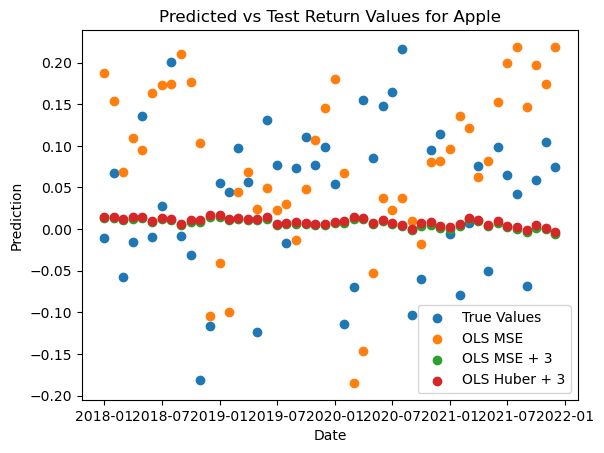

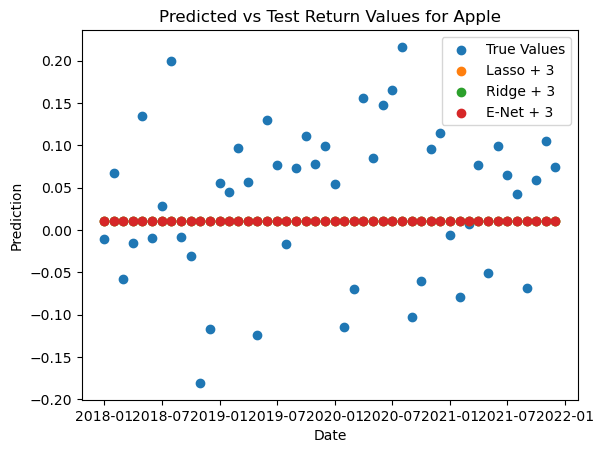

In [41]:
m = 0
apple_index = []
apple_ret = []
apple_date = []
OLS_MSE_pred_apple=[]
OLS_MSE_pred_3_apple = []
OLS_Huber_pred_3_apple = []
lasso_3_pred_apple = []
ridge_3_pred_apple = []
enet_3_pred_apple = []
for i in np.arange(len(test_top)):
    if test_top['permno'].values[i] == 14593:
        apple_index.append(i)
        m+=1
for i in apple_index:
    apple_ret.append(test_top['RET'].values[i])
    OLS_MSE_pred_apple.append(OLS_MSE_pred[i])
    OLS_MSE_pred_3_apple.append(OLS_MSE_pred_3[i])
    OLS_Huber_pred_3_apple.append(OLS_Huber_pred_3[i])
    lasso_3_pred_apple.append(lasso_pred_3[i])
    ridge_3_pred_apple.append(ridge_3_pred[i])
    enet_3_pred_apple.append(enet_3_pred[i])
    apple_date.append(test_top['DATE'].values[i])

apple_ret=np.array(apple_ret).reshape(len(apple_ret),1)
OLS_MSE_pred_apple=np.array(OLS_MSE_pred_apple).reshape(len(OLS_MSE_pred_apple),1)
OLS_MSE_pred_3_apple=np.array(OLS_MSE_pred_3_apple).reshape(len(OLS_MSE_pred_3_apple),1)
OLS_Huber_pred_3_apple=np.array(OLS_Huber_pred_3_apple).reshape(len(OLS_Huber_pred_3_apple),1)
lasso_3_pred_apple=np.array(lasso_3_pred_apple).reshape(len(lasso_3_pred_apple),1)
ridge_3_pred_apple=np.array(ridge_3_pred_apple).reshape(len(ridge_3_pred_apple),1)
enet_3_pred_apple=np.array(enet_3_pred_apple).reshape(len(enet_3_pred_apple),1)
apple_date=np.array(apple_date).reshape(len(apple_date),1)

apple_date = pd.to_datetime(apple_date.flatten().astype(str), format='%Y%m')

plt.scatter(apple_date,apple_ret,label='True Values')
plt.scatter(apple_date,OLS_MSE_pred_apple,label='OLS MSE')
plt.scatter(apple_date,OLS_MSE_pred_3_apple,label='OLS MSE + 3')
plt.scatter(apple_date,OLS_Huber_pred_3_apple,label='OLS Huber + 3')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Predicted vs Test Return Values for Apple')
plt.savefig('plot.png')

plt.figure()
plt.scatter(apple_date,apple_ret,label='True Values')
plt.scatter(apple_date,lasso_3_pred_apple,label='Lasso + 3')
plt.scatter(apple_date,ridge_3_pred_apple,label='Ridge + 3')
plt.scatter(apple_date,enet_3_pred_apple,label='E-Net + 3')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Predicted vs Test Return Values for Apple')
plt.savefig('plot1.png')

(48, 1)


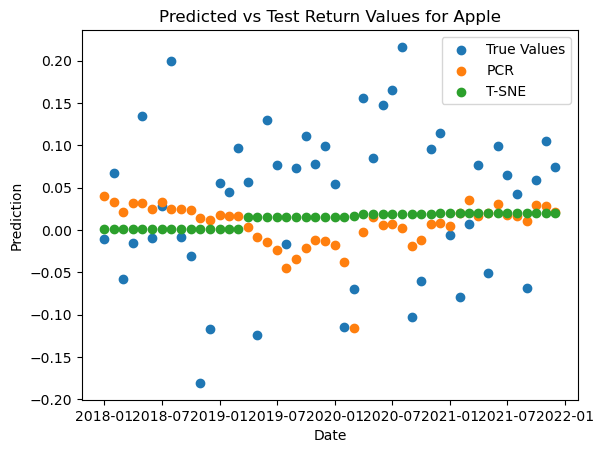

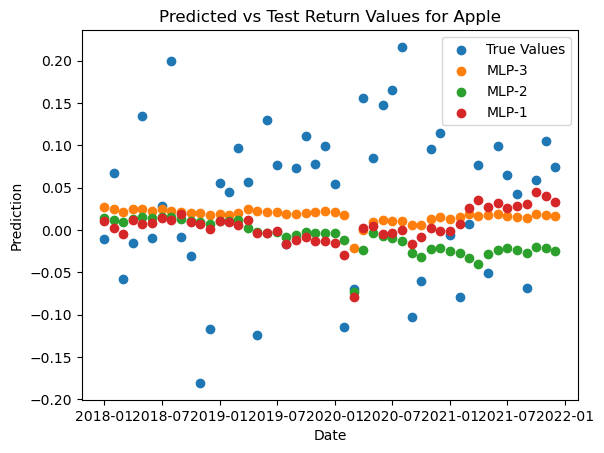

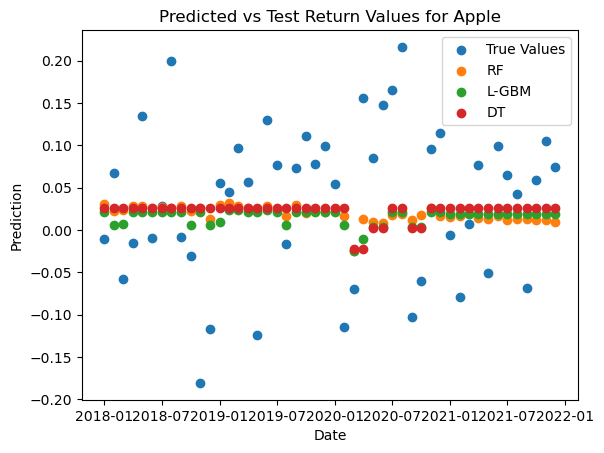

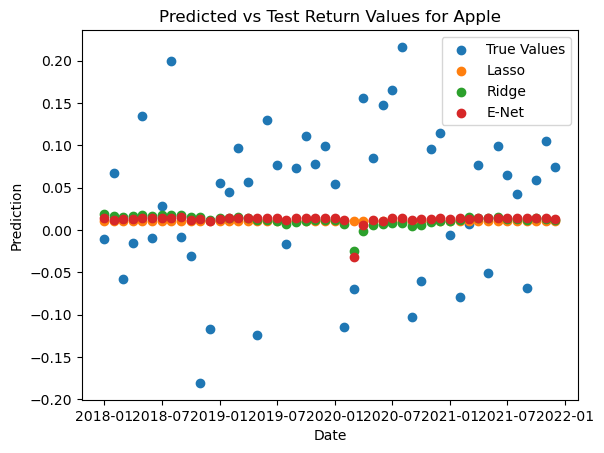

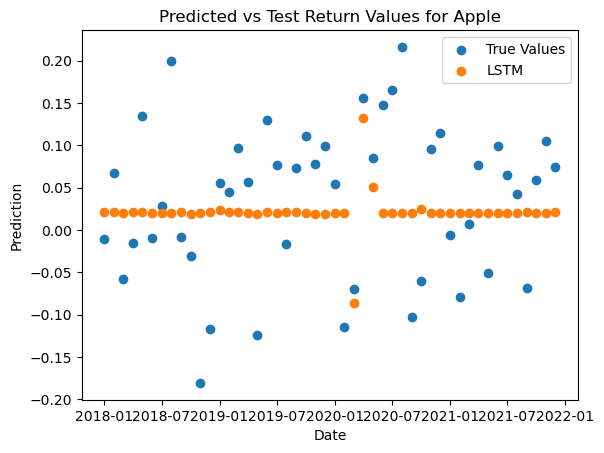

In [43]:
LSTM_top = pd.read_csv('lstm_top.csv')['pred'][apple_index]
LSTM_top = np.array(LSTM_top).reshape(len(LSTM_top),1)
pcr_top = pd.read_csv('pcr_top.csv')['pred'][apple_index]
pcr_top = np.array(pcr_top).reshape(len(pcr_top),1)
tsne_top = pd.read_csv('tsne_top.csv')['pred'][apple_index]
tsne_top = np.array(tsne_top).reshape(len(tsne_top),1)
plt.figure()
plt.scatter(apple_date,apple_ret,label='True Values')
plt.scatter(apple_date,pcr_top,label='PCR')
plt.scatter(apple_date,tsne_top,label='T-SNE')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Predicted vs Test Return Values for Apple')
plt.savefig('plot2.png')

mlp3_top = pd.read_csv('output_mlp3.csv')['pred'][apple_index]
mlp3_top = np.array(mlp3_top).reshape(len(mlp3_top),1)
mlp2_top = pd.read_csv('output_mlp2.csv')['pred'][apple_index]
mlp2_top = np.array(mlp2_top).reshape(len(mlp2_top),1)
mlp1_top = pd.read_csv('output_mlp1.csv')['pred'][apple_index]
mlp1_top = np.array(mlp1_top).reshape(len(mlp1_top),1)
plt.figure()
plt.scatter(apple_date,apple_ret,label='True Values')
plt.scatter(apple_date,mlp3_top,label='MLP-3')
plt.scatter(apple_date,mlp2_top,label='MLP-2')
plt.scatter(apple_date,mlp1_top,label='MLP-1')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Predicted vs Test Return Values for Apple')
plt.savefig('plot3.png')

rf_top = pd.read_csv('random_forest.csv')['pred'][apple_index]
rf_top = np.array(rf_top).reshape(len(rf_top),1)
lightGBM_top = pd.read_csv('lightGBM.csv')['pred'][apple_index]
lightGBM_top = np.array(lightGBM_top).reshape(len(lightGBM_top),1)
dt_top = pd.read_csv('decision_tree.csv')['pred'][apple_index]
dt_top = np.array(dt_top).reshape(len(dt_top),1)
plt.figure()
plt.scatter(apple_date,apple_ret,label='True Values')
plt.scatter(apple_date,rf_top,label='RF')
plt.scatter(apple_date,lightGBM_top,label='L-GBM')
plt.scatter(apple_date,dt_top,label='DT')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Predicted vs Test Return Values for Apple')
plt.savefig('plot4.png')

Lasso_top = pd.read_csv('OLS_LASSO.csv')['pred'][apple_index]
Lasso_top = np.array(Lasso_top).reshape(len(Lasso_top),1)
Ridge_top = pd.read_csv('OLS_Ridge.csv')['pred'][apple_index]
Ridge_top = np.array(Ridge_top).reshape(len(Ridge_top),1)
Enet_top = pd.read_csv('OLS_ENet.csv')['pred'][apple_index]
Enet_top = np.array(Enet_top).reshape(len(Enet_top),1)
plt.figure()
plt.scatter(apple_date,apple_ret,label='True Values')
plt.scatter(apple_date,Lasso_top,label='Lasso')
plt.scatter(apple_date,Ridge_top,label='Ridge')
plt.scatter(apple_date,Enet_top,label='E-Net')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Predicted vs Test Return Values for Apple')
plt.savefig('plot5.png')

plt.figure()
plt.scatter(apple_date,apple_ret,label='True Values')
plt.scatter(apple_date,LSTM_top,label='LSTM')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Predicted vs Test Return Values for Apple')
plt.savefig('plot6.png')


print(Enet_top.shape)



Linear Model with Elastic Net reuglarization, using Huber loss function

In [ ]:
Xtrain = [train.drop(columns=['DATE','permno','RET']).values,train_bottom.drop(columns=['DATE','permno','RET']).values,train_top.drop(columns=['DATE','permno','RET']).values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test.drop(columns=['DATE','permno','RET']).values,test_bottom.drop(columns=['DATE','permno','RET']).values,test_top.drop(columns=['DATE','permno','RET']).values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val.drop(columns=['DATE','permno','RET']).values,val_bottom.drop(columns=['DATE','permno','RET']).values,val_top.drop(columns=['DATE','permno','RET']).values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

i = 0
gammas = 10**np.linspace(-6,6,10)
lamdas = 10**np.linspace(-6,6,10)
l1_ratios = 10**np.linspace(-6,0,10)

while i<3:
    best_R2_OOS = -np.inf
    best_gamma=0
    best_lamda=0
    best_l1_ratio = 0
    model = linear_model.LinearRegression()
    model.fit(X=Xtrain[i],y=Ytrain[i])
    pred = model.predict(X=Xtrain[i])
    epsilon=np.max((np.percentile(np.abs(Ytrain[i]-pred),99.9),1))
    for gamma in gammas:
        for lamda in lamdas:
            for rho in l1_ratios:
                theta = prox_grad(gamma=gamma,lamda=lamda,X=Xtrain[i],y=Ytrain[i],model='elastic',epsilon=epsilon,rho=rho)
                pred = fit_APG(Xtest=Xval[i],theta=theta)
                R2_OOS = R_oss(true=Yval[i],pred=y_predVal)
                if R2_OOS > best_R2_OOS:
                    best_R2_OOS = R2_OOS
                    best_gamma = gamma
                    best_lamda = lamda
                    best_l1_ratio = rho
    theta = prox_grad(gamma=best_gamma,lamda=best_lamda,X=Xtrain[i],y=Ytrain[i],model='elastic',epsilon=epsilon,rho=best_l1_ratio)
    pred = fit_APG(Xtest=Xtest[i],theta=theta)
    R2_OOS = R_oss(true=Ytrue[i],pred=pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
    i+=1

Linear Model with Elastic Net regularization, using Huber loss function. Limiting X dataset to size, book-to-market, momentum. 

In [ ]:
Xtrain = [train[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,train_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrain = [train['RET'].values,train_bottom['RET'].values,train_top['RET'].values]

Xtest = [test[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,test_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Ytrue = [test['RET'].values,test_bottom['RET'].values,test_top['RET'].values]

Xval = [val[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_bottom[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values,val_top[['mvel1','bm','mom1m','mom6m','mom12m','mom36m']].values]
Yval = [val['RET'].values,val_bottom['RET'].values,val_top['RET'].values]

i = 0
gammas = 10**np.linspace(-6,6,10)
lamdas = 10**np.linspace(-6,6,10)
l1_ratios = 10**np.linspace(-6,0,10)

while i<3:
    best_R2_OOS = -np.inf
    best_gamma=0
    best_lamda=0
    best_l1_ratio = 0
    model = linear_model.LinearRegression()
    model.fit(X=Xtrain[i],y=Ytrain[i])
    pred = model.predict(X=Xtrain[i])
    epsilon=np.max((np.percentile(np.abs(Ytrain[i]-pred),99.9),1))
    for gamma in gammas:
        for lamda in lamdas:
            for rho in l1_ratios:
                theta = prox_grad(gamma=gamma,lamda=lamda,X=Xtrain[i],y=Ytrain[i],model='elastic',epsilon=epsilon,rho=rho)
                pred = fit_APG(Xtest=Xval[i],theta=theta)
                R2_OOS = R_oss(true=Yval[i],pred=y_predVal)
                if R2_OOS > best_R2_OOS:
                    best_R2_OOS = R2_OOS
                    best_gamma = gamma
                    best_lamda = lamda
                    best_l1_ratio = rho
    theta = prox_grad(gamma=best_gamma,lamda=best_lamda,X=Xtrain[i],y=Ytrain[i],model='elastic',epsilon=epsilon,rho=best_l1_ratio)
    pred = fit_APG(Xtest=Xtest[i],theta=theta)
    R2_OOS = R_oss(true=Ytrue[i],pred=pred)
    if i == 0:
        print(f'Out of sample R2 value for complete dataset is: {R2_OOS}\n')
    if i == 1:
        print(f'Out of sample R2 value for bottom performers of dataset is: {R2_OOS}\n')
    if i == 2:
        print(f'Out of sample R2 value for top performers of dataset is: {R2_OOS}\n')
    i+=1

[-0.088191  0.079484 -0.015975 ...  0.071545 -0.065069 -0.076855]
[0. 0. 0. ... 0. 0. 0.]
In sample R2 value for complete dataset is: -0.0024828921845239105

Out of sample R2 value for complete dataset is: 0.0

[-0.185185 -0.0625   -0.21123  ...  0.157965 -0.171607  0.001463]
[0. 0. 0. ... 0. 0. 0.]
In sample R2 value for bottom performers of dataset is: -0.0024828921845239105

Out of sample R2 value for bottom performers of dataset is: 0.0

[ 0.074229 -0.068037 -0.001236 ...  0.152268  0.10736   0.010708]
[0. 0. 0. ... 0. 0. 0.]
In sample R2 value for top performers of dataset is: -0.0024828921845239105

Out of sample R2 value for top performers of dataset is: 0.0

